In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from keras import optimizers
from tensorflow.keras.layers import Dense,Activation,Dropout
from keras.models import model_from_json
from keras.callbacks import ModelCheckpoint, TensorBoard
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import metrics
import time

In [2]:
# constants
window_length = 1
epochs = 200
batch = 64
lr = 0.0001

In [3]:
df =pd.read_csv("ME1.csv")


In [4]:
df.drop('time', axis=1, inplace=True)

In [5]:
df.describe()

,1011001,1011002,1011003,1011004,1011005,1011006,1011007,1011008,1011009,1011010,...,1011264,1011265,1011266,1011267,1011270,1011271,1011272,1011273,1011466,1011467
count,3264.000000,3264.000000,3264.000000,3264.000000,3264.000000,3264.000000,3264.000000,3264.000000,3264.000000,3264.000000,...,3264.0,3264.000000,3264.000000,3264.000000,3264.000000,3264.000000,3264.000000,3264.0,3264.000000,3264.000000
mean,267.808414,269.948716,267.808414,268.075953,268.343496,268.075953,268.075953,267.808414,350.503177,267.540871,...,0.0,268.243157,53.307737,60.416172,512.199055,13375.976407,0.000140,60.0,40.646076,34.392833
std,5.743727,5.789631,5.743727,5.749464,5.755203,5.749464,5.749464,5.743727,10.623168,5.737990,...,0.0,5.753052,1.018743,0.038946,0.362351,333.010965,0.000316,0.0,2.237534,1.893298
min,266.592102,268.722687,266.592102,266.858429,267.124756,266.858429,266.858429,266.592102,348.369965,266.325775,...,0.0,267.024872,40.378376,60.408234,512.126038,13314.745120,0.000000,60.0,40.227703,34.038826
25%,266.592102,268.722687,266.592102,266.858429,267.124756,266.858429,266.858429,266.592102,348.369965,266.325775,...,0.0,267.024872,53.408504,60.408302,512.126038,13314.765630,0.000000,60.0,40.227795,34.038902
50%,266.592102,268.722687,266.592102,266.858429,267.124756,266.858429,266.858429,266.592102,348.369965,266.325775,...,0.0,267.024872,53.409683,60.408318,512.126038,13314.776370,0.000000,60.0,40.227795,34.038902
75%,266.592102,268.722687,266.592102,266.858429,267.124756,266.858429,266.858429,266.592102,348.369965,266.325775,...,0.0,267.024872,53.409683,60.408337,512.126038,13314.776370,0.000000,60.0,40.227833,34.038937
max,315.177887,317.696777,315.177887,315.492798,315.807617,315.492798,315.492798,315.177887,443.469605,314.863068,...,0.0,315.689545,56.966232,60.777531,515.137390,16778.548830,0.001156,60.0,63.484425,53.717590


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

def generate_datasets_for_training(data, window_size,scale=True, scaler_type=StandardScaler):
    _l = len(data) 
    data = scaler_type().fit_transform(data)
    Xs = []
    Ys = []
    for i in range(0, (_l - window_size)):
        # because this is an autoencoder - our Ys are the same as our Xs. 
        Xs.append(data[i:i+window_size])
        Ys.append(data[i:i+window_size])
    tr_x, tr_y, ts_x, ts_y = [np.array(x) for x in train_test_split(Xs, Ys)]
    assert tr_x.shape[2] == ts_x.shape[2] == (data.shape[1] if (type(data) == np.ndarray) else len(data))
    return  (tr_x.shape[2], tr_x, tr_y, ts_x, ts_y)

In [7]:
feats, X, Y, XX, YY = generate_datasets_for_training(df, window_length)

In [8]:
feats, X.shape, Y.shape, XX.shape, YY.shape

(66, (2447, 1, 66), (816, 1, 66), (2447, 1, 66), (816, 1, 66))

In [9]:

from keras import metrics
import keras
import tensorflow as tf
import os

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=1e-2, patience=5, verbose=1, mode='auto',
    baseline=None, restore_best_weights=True)

feats, X, Y, XX, YY = generate_datasets_for_training(df, window_length)

lstm_autoencoder = keras.Sequential()
lstm_autoencoder.add(keras.layers.LSTM(64, kernel_initializer='he_uniform', batch_input_shape=(None, window_length, feats), return_sequences=True, name='encoder_1'))
# lstm_autoencoder.add(Dropout(0.2))

lstm_autoencoder.add(keras.layers.LSTM(32, kernel_initializer='he_uniform', return_sequences=True, name='encoder_2'))
# lstm_autoencoder.add(Dropout(0.2))

lstm_autoencoder.add(keras.layers.LSTM(16, kernel_initializer='he_uniform', return_sequences=False, name='encoder_3'))
lstm_autoencoder.add(keras.layers.RepeatVector(window_length, name='encoder_decoder_bridge'))

lstm_autoencoder.add(keras.layers.LSTM(16, kernel_initializer='he_uniform', return_sequences=True, name='decoder_1'))
# lstm_autoencoder.add(Dropout(0.2))

lstm_autoencoder.add(keras.layers.LSTM(32, kernel_initializer='he_uniform', return_sequences=True, name='decoder_2'))
# lstm_autoencoder.add(Dropout(0.2))

lstm_autoencoder.add(keras.layers.LSTM(64, kernel_initializer='he_uniform', return_sequences=True, name='decoder_3'))
lstm_autoencoder.add(keras.layers.TimeDistributed(keras.layers.Dense(feats)))
lstm_autoencoder.compile(loss="mse",optimizer='adam')
# lstm_autoencoder.build()
print(lstm_autoencoder.summary())

# model.fit(x=X, y=Y, validation_data=(XX, YY), epochs=100, batch_size=batch_size, shuffle=True, callbacks=[early_stop],verbose=1)
# model.fit(x=X, y=XX, validation_data=(Y, YY), epochs=100, batch_size=batch_size, shuffle=True, callbacks=[early_stop],verbose=1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_1 (LSTM)             (None, 1, 64)             33536     
_________________________________________________________________
encoder_2 (LSTM)             (None, 1, 32)             12416     
_________________________________________________________________
encoder_3 (LSTM)             (None, 16)                3136      
_________________________________________________________________
encoder_decoder_bridge (Repe (None, 1, 16)             0         
_________________________________________________________________
decoder_1 (LSTM)             (None, 1, 16)             2112      
_________________________________________________________________
decoder_2 (LSTM)             (None, 1, 32)             6272      
_________________________________________________________________
decoder_3 (LSTM)             (None, 1, 64)             2

In [10]:
adam = optimizers.Adam(lr)
lstm_autoencoder.compile(loss='mse', optimizer=adam)

cp = ModelCheckpoint(filepath="lstm_autoencoder_classifier.h5",
                               save_best_only=True,
                               verbose=0)

tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

lstm_autoencoder_history = lstm_autoencoder.fit(X, X, 
                                                epochs=epochs, 
                                                batch_size=batch, 
                                                validation_data=(Y, Y),
                                                verbose=2).history

Epoch 1/200
39/39 - 5s - loss: 0.9917 - val_loss: 0.9019
Epoch 2/200
39/39 - 1s - loss: 0.9905 - val_loss: 0.9006
Epoch 3/200
39/39 - 1s - loss: 0.9888 - val_loss: 0.8986
Epoch 4/200
39/39 - 1s - loss: 0.9862 - val_loss: 0.8957
Epoch 5/200
39/39 - 1s - loss: 0.9822 - val_loss: 0.8908
Epoch 6/200
39/39 - 1s - loss: 0.9755 - val_loss: 0.8827
Epoch 7/200
39/39 - 1s - loss: 0.9643 - val_loss: 0.8691
Epoch 8/200
39/39 - 1s - loss: 0.9465 - val_loss: 0.8483
Epoch 9/200
39/39 - 1s - loss: 0.9196 - val_loss: 0.8192
Epoch 10/200
39/39 - 1s - loss: 0.8838 - val_loss: 0.7822
Epoch 11/200
39/39 - 1s - loss: 0.8383 - val_loss: 0.7362
Epoch 12/200
39/39 - 1s - loss: 0.7862 - val_loss: 0.6881
Epoch 13/200
39/39 - 1s - loss: 0.7303 - val_loss: 0.6387
Epoch 14/200
39/39 - 1s - loss: 0.6782 - val_loss: 0.5915
Epoch 15/200
39/39 - 1s - loss: 0.6259 - val_loss: 0.5431
Epoch 16/200
39/39 - 1s - loss: 0.5764 - val_loss: 0.4981
Epoch 17/200
39/39 - 1s - loss: 0.5298 - val_loss: 0.4569
Epoch 18/200
39/39 - 1s

Epoch 142/200
39/39 - 1s - loss: 0.0425 - val_loss: 0.0395
Epoch 143/200
39/39 - 1s - loss: 0.0425 - val_loss: 0.0389
Epoch 144/200
39/39 - 1s - loss: 0.0419 - val_loss: 0.0387
Epoch 145/200
39/39 - 1s - loss: 0.0415 - val_loss: 0.0385
Epoch 146/200
39/39 - 1s - loss: 0.0412 - val_loss: 0.0384
Epoch 147/200
39/39 - 1s - loss: 0.0409 - val_loss: 0.0381
Epoch 148/200
39/39 - 1s - loss: 0.0407 - val_loss: 0.0379
Epoch 149/200
39/39 - 1s - loss: 0.0406 - val_loss: 0.0380
Epoch 150/200
39/39 - 1s - loss: 0.0403 - val_loss: 0.0377
Epoch 151/200
39/39 - 1s - loss: 0.0399 - val_loss: 0.0375
Epoch 152/200
39/39 - 1s - loss: 0.0398 - val_loss: 0.0372
Epoch 153/200
39/39 - 1s - loss: 0.0395 - val_loss: 0.0372
Epoch 154/200
39/39 - 1s - loss: 0.0392 - val_loss: 0.0369
Epoch 155/200
39/39 - 1s - loss: 0.0391 - val_loss: 0.0368
Epoch 156/200
39/39 - 1s - loss: 0.0389 - val_loss: 0.0369
Epoch 157/200
39/39 - 1s - loss: 0.0391 - val_loss: 0.0368
Epoch 158/200
39/39 - 1s - loss: 0.0388 - val_loss: 0.03

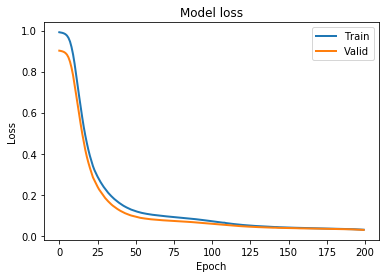

In [11]:
plt.plot(lstm_autoencoder_history['loss'], linewidth=2, label='Train')
plt.plot(lstm_autoencoder_history['val_loss'], linewidth=2, label='Valid')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [12]:
def flatten(X):
    '''
    Flatten a 3D array.
    
    Input
    X            A 3D array for lstm, where the array is sample x timesteps x features.
    
    Output
    flattened_X  A 2D array, sample x features.
    '''
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)

In [15]:
resconstructions = lstm_autoencoder.predict(X)
# score1 = np.sqrt(metrics.mean_squared_error(resconstructions,X))
# # print(score1)

train_loss = tf.keras.losses.mae(resconstructions,X)
# print(train_loss)


# plt.hist(train_loss,bins=50)

In [16]:
np.mean(train_loss)

0.043273098187299

In [17]:
np.std(train_loss)

0.04024295358307432

In [18]:
threshold = np.mean(train_loss) + 3*np.std(train_loss)
threshold

0.16400195893652197

# Inference

In [19]:
normal_data = pd.read_csv("ME1.csv")
normal_data.drop('time', axis=1, inplace=True)
abnormal_data = pd.read_csv("Test_Alarms.csv")

In [20]:
normal_data.shape, abnormal_data.shape

((3264, 66), (3586, 66))

In [30]:
inference_data = abnormal_data

In [31]:
feats_, X_, Y_, XX_, YY_ = generate_datasets_for_training(inference_data, window_length)
test_data = X_


In [32]:
inference_predictions_resconstruction = lstm_autoencoder.predict(test_data)

inference_loss = tf.keras.losses.mae(inference_predictions_resconstruction,test_data)



for i in range(0,len(inference_loss)):

    inference_res = tf.math.less(inference_loss[0][0],threshold)

    if inference_res:
        print(i ,"Normal ")
    else:
        print(i, "Anomaly Detected")

0 Anomaly Detected
1 Anomaly Detected
2 Anomaly Detected
3 Anomaly Detected
4 Anomaly Detected
5 Anomaly Detected
6 Anomaly Detected
7 Anomaly Detected
8 Anomaly Detected
9 Anomaly Detected
10 Anomaly Detected
11 Anomaly Detected
12 Anomaly Detected
13 Anomaly Detected
14 Anomaly Detected
15 Anomaly Detected
16 Anomaly Detected
17 Anomaly Detected
18 Anomaly Detected
19 Anomaly Detected
20 Anomaly Detected
21 Anomaly Detected
22 Anomaly Detected
23 Anomaly Detected
24 Anomaly Detected
25 Anomaly Detected
26 Anomaly Detected
27 Anomaly Detected
28 Anomaly Detected
29 Anomaly Detected
30 Anomaly Detected
31 Anomaly Detected
32 Anomaly Detected
33 Anomaly Detected
34 Anomaly Detected
35 Anomaly Detected
36 Anomaly Detected
37 Anomaly Detected
38 Anomaly Detected
39 Anomaly Detected
40 Anomaly Detected
41 Anomaly Detected
42 Anomaly Detected
43 Anomaly Detected
44 Anomaly Detected
45 Anomaly Detected
46 Anomaly Detected
47 Anomaly Detected
48 Anomaly Detected
49 Anomaly Detected
50 Anomaly

423 Anomaly Detected
424 Anomaly Detected
425 Anomaly Detected
426 Anomaly Detected
427 Anomaly Detected
428 Anomaly Detected
429 Anomaly Detected
430 Anomaly Detected
431 Anomaly Detected
432 Anomaly Detected
433 Anomaly Detected
434 Anomaly Detected
435 Anomaly Detected
436 Anomaly Detected
437 Anomaly Detected
438 Anomaly Detected
439 Anomaly Detected
440 Anomaly Detected
441 Anomaly Detected
442 Anomaly Detected
443 Anomaly Detected
444 Anomaly Detected
445 Anomaly Detected
446 Anomaly Detected
447 Anomaly Detected
448 Anomaly Detected
449 Anomaly Detected
450 Anomaly Detected
451 Anomaly Detected
452 Anomaly Detected
453 Anomaly Detected
454 Anomaly Detected
455 Anomaly Detected
456 Anomaly Detected
457 Anomaly Detected
458 Anomaly Detected
459 Anomaly Detected
460 Anomaly Detected
461 Anomaly Detected
462 Anomaly Detected
463 Anomaly Detected
464 Anomaly Detected
465 Anomaly Detected
466 Anomaly Detected
467 Anomaly Detected
468 Anomaly Detected
469 Anomaly Detected
470 Anomaly D

833 Anomaly Detected
834 Anomaly Detected
835 Anomaly Detected
836 Anomaly Detected
837 Anomaly Detected
838 Anomaly Detected
839 Anomaly Detected
840 Anomaly Detected
841 Anomaly Detected
842 Anomaly Detected
843 Anomaly Detected
844 Anomaly Detected
845 Anomaly Detected
846 Anomaly Detected
847 Anomaly Detected
848 Anomaly Detected
849 Anomaly Detected
850 Anomaly Detected
851 Anomaly Detected
852 Anomaly Detected
853 Anomaly Detected
854 Anomaly Detected
855 Anomaly Detected
856 Anomaly Detected
857 Anomaly Detected
858 Anomaly Detected
859 Anomaly Detected
860 Anomaly Detected
861 Anomaly Detected
862 Anomaly Detected
863 Anomaly Detected
864 Anomaly Detected
865 Anomaly Detected
866 Anomaly Detected
867 Anomaly Detected
868 Anomaly Detected
869 Anomaly Detected
870 Anomaly Detected
871 Anomaly Detected
872 Anomaly Detected
873 Anomaly Detected
874 Anomaly Detected
875 Anomaly Detected
876 Anomaly Detected
877 Anomaly Detected
878 Anomaly Detected
879 Anomaly Detected
880 Anomaly D

1224 Anomaly Detected
1225 Anomaly Detected
1226 Anomaly Detected
1227 Anomaly Detected
1228 Anomaly Detected
1229 Anomaly Detected
1230 Anomaly Detected
1231 Anomaly Detected
1232 Anomaly Detected
1233 Anomaly Detected
1234 Anomaly Detected
1235 Anomaly Detected
1236 Anomaly Detected
1237 Anomaly Detected
1238 Anomaly Detected
1239 Anomaly Detected
1240 Anomaly Detected
1241 Anomaly Detected
1242 Anomaly Detected
1243 Anomaly Detected
1244 Anomaly Detected
1245 Anomaly Detected
1246 Anomaly Detected
1247 Anomaly Detected
1248 Anomaly Detected
1249 Anomaly Detected
1250 Anomaly Detected
1251 Anomaly Detected
1252 Anomaly Detected
1253 Anomaly Detected
1254 Anomaly Detected
1255 Anomaly Detected
1256 Anomaly Detected
1257 Anomaly Detected
1258 Anomaly Detected
1259 Anomaly Detected
1260 Anomaly Detected
1261 Anomaly Detected
1262 Anomaly Detected
1263 Anomaly Detected
1264 Anomaly Detected
1265 Anomaly Detected
1266 Anomaly Detected
1267 Anomaly Detected
1268 Anomaly Detected
1269 Anoma

1620 Anomaly Detected
1621 Anomaly Detected
1622 Anomaly Detected
1623 Anomaly Detected
1624 Anomaly Detected
1625 Anomaly Detected
1626 Anomaly Detected
1627 Anomaly Detected
1628 Anomaly Detected
1629 Anomaly Detected
1630 Anomaly Detected
1631 Anomaly Detected
1632 Anomaly Detected
1633 Anomaly Detected
1634 Anomaly Detected
1635 Anomaly Detected
1636 Anomaly Detected
1637 Anomaly Detected
1638 Anomaly Detected
1639 Anomaly Detected
1640 Anomaly Detected
1641 Anomaly Detected
1642 Anomaly Detected
1643 Anomaly Detected
1644 Anomaly Detected
1645 Anomaly Detected
1646 Anomaly Detected
1647 Anomaly Detected
1648 Anomaly Detected
1649 Anomaly Detected
1650 Anomaly Detected
1651 Anomaly Detected
1652 Anomaly Detected
1653 Anomaly Detected
1654 Anomaly Detected
1655 Anomaly Detected
1656 Anomaly Detected
1657 Anomaly Detected
1658 Anomaly Detected
1659 Anomaly Detected
1660 Anomaly Detected
1661 Anomaly Detected
1662 Anomaly Detected
1663 Anomaly Detected
1664 Anomaly Detected
1665 Anoma

2040 Anomaly Detected
2041 Anomaly Detected
2042 Anomaly Detected
2043 Anomaly Detected
2044 Anomaly Detected
2045 Anomaly Detected
2046 Anomaly Detected
2047 Anomaly Detected
2048 Anomaly Detected
2049 Anomaly Detected
2050 Anomaly Detected
2051 Anomaly Detected
2052 Anomaly Detected
2053 Anomaly Detected
2054 Anomaly Detected
2055 Anomaly Detected
2056 Anomaly Detected
2057 Anomaly Detected
2058 Anomaly Detected
2059 Anomaly Detected
2060 Anomaly Detected
2061 Anomaly Detected
2062 Anomaly Detected
2063 Anomaly Detected
2064 Anomaly Detected
2065 Anomaly Detected
2066 Anomaly Detected
2067 Anomaly Detected
2068 Anomaly Detected
2069 Anomaly Detected
2070 Anomaly Detected
2071 Anomaly Detected
2072 Anomaly Detected
2073 Anomaly Detected
2074 Anomaly Detected
2075 Anomaly Detected
2076 Anomaly Detected
2077 Anomaly Detected
2078 Anomaly Detected
2079 Anomaly Detected
2080 Anomaly Detected
2081 Anomaly Detected
2082 Anomaly Detected
2083 Anomaly Detected
2084 Anomaly Detected
2085 Anoma

2451 Anomaly Detected
2452 Anomaly Detected
2453 Anomaly Detected
2454 Anomaly Detected
2455 Anomaly Detected
2456 Anomaly Detected
2457 Anomaly Detected
2458 Anomaly Detected
2459 Anomaly Detected
2460 Anomaly Detected
2461 Anomaly Detected
2462 Anomaly Detected
2463 Anomaly Detected
2464 Anomaly Detected
2465 Anomaly Detected
2466 Anomaly Detected
2467 Anomaly Detected
2468 Anomaly Detected
2469 Anomaly Detected
2470 Anomaly Detected
2471 Anomaly Detected
2472 Anomaly Detected
2473 Anomaly Detected
2474 Anomaly Detected
2475 Anomaly Detected
2476 Anomaly Detected
2477 Anomaly Detected
2478 Anomaly Detected
2479 Anomaly Detected
2480 Anomaly Detected
2481 Anomaly Detected
2482 Anomaly Detected
2483 Anomaly Detected
2484 Anomaly Detected
2485 Anomaly Detected
2486 Anomaly Detected
2487 Anomaly Detected
2488 Anomaly Detected
2489 Anomaly Detected
2490 Anomaly Detected
2491 Anomaly Detected
2492 Anomaly Detected
2493 Anomaly Detected
2494 Anomaly Detected
2495 Anomaly Detected
2496 Anoma